#Clustering the [Enron e-mail corpus](http://www.cs.cmu.edu/~./enron/) using the Infinite Relational Model

---

Let's setup our environment

In [9]:
%matplotlib inline
import pickle
import time
import itertools as it
import numpy as np
import matplotlib.pylab as plt
import matplotlib.patches as patches
from multiprocessing import cpu_count
import seaborn as sns
sns.set_context('talk')

Below are the functions from datamicroscopes we'll be using to cluster the data

In [10]:
from microscopes.common.rng import rng
from microscopes.common.relation.dataview import numpy_dataview
from microscopes.models import bb as beta_bernoulli
from microscopes.irm.definition import model_definition
from microscopes.irm import model, runner, query
from microscopes.kernels import parallel
from microscopes.common.query import groups, zmatrix_heuristic_block_ordering, zmatrix_reorder

We've made a set of utilities especially for this dataset, `enron_utils`. We'll include these as well.

We have downloaded the data and preprocessed it as suggested by [Ishiguro et al. 2012](http://www.kecl.ntt.co.jp/as/members/ishiguro/open/2012AISTATS.pdf).  The results of the scirpt have been stored in the `results.p`.

`enron_crawler.py` in the kernels repo includes the script to create `results.p`
`enron_crawler.py` and `enron_utils.py` can be found at https://github.com/datamicroscopes/release/tree/master/examples

In [11]:
import enron_utils

Let's load the data and make a binary matrix to represent email communication between individuals

In this matrix, $X_{i,j} = 1$ if and only if person$_{i}$ sent an email to person$_{j}$

In [12]:
with open('results.p') as fp:
    communications = pickle.load(fp)
def allnames(o):
    for k, v in o:
        yield [k] + list(v)
names = set(it.chain.from_iterable(allnames(communications)))
names = sorted(list(names))
namemap = { name : idx for idx, name in enumerate(names) }
N = len(names)
communications_relation = np.zeros((N, N), dtype=np.bool)
for sender, receivers in communications:
    sender_id = namemap[sender]
    for receiver in receivers:
        receiver_id = namemap[receiver]
        communications_relation[sender_id, receiver_id] = True

print "%d names in the corpus" % N

115 names in the corpus


Let's visualize the communication matrix

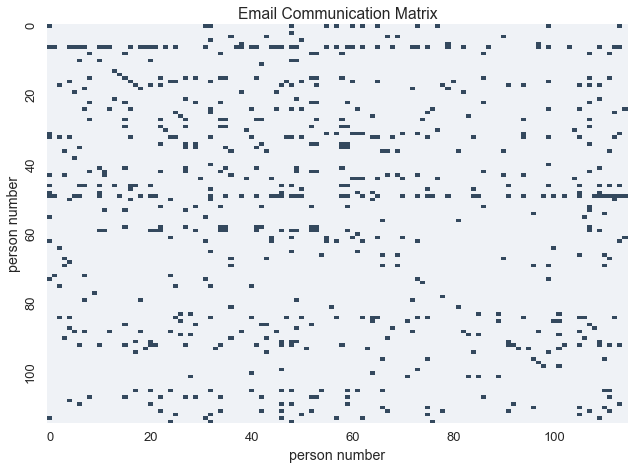

In [13]:
blue_cmap = sns.light_palette("#34495e", as_cmap=True)
labels = [i if i%20 == 0 else '' for i in xrange(N)]
sns.heatmap(communications_relation, cmap=blue_cmap, linewidths=0, cbar=False, xticklabels=labels, yticklabels=labels) 
plt.xlabel('person number')
plt.ylabel('person number')
plt.title('Email Communication Matrix')

Now, let's learn the underlying clusters using the Inifinite Relational Model

Let's import the necessary functions from datamicroscopes

There are 5 steps necessary in inferring a model with datamicroscopes:
1. define the model
2. load the data
3. initialize the model
4. define the runners (MCMC chains)
5. run the runners

Let's start by defining the model and loading the data

To define our model, we need to specify our domains and relations

Our domains are described in a list of the cardinalities of each domain

Our releations are in a list of tuples which refer to the indicies of each domain and the model type

In this case, the our domain is users, which is of size $N$

Our relations are users to users, both of cardinality $N$, and we model the relation with beta-bernoulli distribution since our data is binary

In [14]:
defn = model_definition([N], [((0, 0), beta_bernoulli)])
views = [numpy_dataview(communications_relation)]
prng = rng()

Next, let's initialize the model and define the runners.  

These runners are our MCMC chains. We'll use `cpu_count` to define our number of chains.

In [ ]:
nchains = cpu_count()
latents = [model.initialize(defn, views, r=prng, cluster_hps=[{'alpha':1e-3}]) for _ in xrange(nchains)]
kc = runner.default_assign_kernel_config(defn)
runners = [runner.runner(defn, views, latent, kc) for latent in latents]
r = parallel.runner(runners)

From here, we can finally run each chain of the sampler 1000 times

In [ ]:
start = time.time()
r.run(r=prng, niters=1000)
print "inference took {} seconds".format(time.time() - start)

Now that we have learned our model let's get our cluster assignments

In [ ]:
infers = r.get_latents()
clusters = groups(infers[0].assignments(0), sort=True)
ordering = list(it.chain.from_iterable(clusters))

Let's sort the communications matrix to highlight our inferred clusters

In [ ]:
z = communications_relation.copy()
z = z[ordering]
z = z[:,ordering]
sizes = map(len, clusters)
boundaries = np.cumsum(sizes)[:-1]

Our model finds suspicious cluster based on the communication data.  Let's color and label these clusters in our communications matrix. 

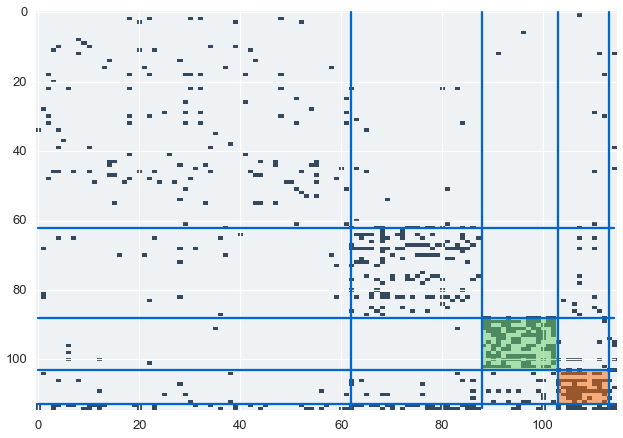

In [11]:
def cluster_with_name(clusters, name, payload=None):
    ident = namemap[name]
    for idx, cluster in enumerate(clusters):
        if ident in cluster:
            return idx, (cluster, payload)
    raise ValueError("could not find name")

suspicious = [
    cluster_with_name(clusters, "horton-s", {"color":"#66CC66", "desc":"The pipeline/regulatory group"}), 


    cluster_with_name(clusters, "skilling-j", {"color":"#FF6600", "desc":"The VIP/executives group"}),
]
suspicious = dict(suspicious)

for idx, (boundary, size) in enumerate(zip(boundaries, sizes)):
    if size < 5:
        continue
    plt.plot(range(N), boundary*np.ones(N), color='#0066CC')
    plt.plot(boundary*np.ones(N), range(N), color='#0066CC')
    if idx in suspicious:
        rect = patches.Rectangle((boundary-size, boundary-size), 
            width=size, height=size, alpha=0.5, fc=suspicious[idx][1]["color"])
        plt.gca().add_patch(rect)
plt.imshow(z, cmap=blue_cmap, interpolation='nearest', aspect='auto')
plt.xlabel('Person ID')
plt.ylabel('Person ID')
plt.title('Cluster Assignments in Enron Dataset')
plt.savefig('enron.png')

We've identified two suspicious clusters.  Let's look at the data to find out who these individuals are

In [12]:
def cluster_names(cluster):
    return [names[idx] for idx in cluster]
def get_full_name(name):
    return enron_utils.FULLNAMES.get(name, name)
def get_title(name):
    return enron_utils.TITLES.get(name, "?")

for cluster, payload in suspicious.values():
    cnames = cluster_names(cluster)
    ctitles = map(get_title, cnames)
    print payload["desc"]
    for n, t in zip(cnames, ctitles):
        print "\t", get_full_name(n), '\t\t"{}"'.format(t)
    print

The pipeline/regulatory group
	Lynn Blair 		"?"
	Shelley Corman 		"Vice President Regulatory Affairs"
	Lindy Donoho 		"Employee"
	Drew Fossum 		"Vice President"
	Tracy Geaccone 		"Employee"
	harris-s 		"?"
	Rod Hayslett 		"Vice President Also Chief Financial Officer and Treasurer"
	Stanley Horton 		"President Enron Gas Pipeline"
	Kevin Hyatt 		"Director Pipeline Business"
	Michelle Lokay 		"Employee Administrative Asisstant"
	Teb Lokey 		"Manager Regulatory Affairs"
	Danny McCarty 		"Vice President"
	mcconnell-m 		"?"
	Darrell Schoolcraft 		"?"
	Kimberly Watson 		"?"

The VIP/executives group
	Rick Buy 		"Manager Chief Risk Management Officer"
	Jeff Dasovich 		"Employee Government Relation Executive"
	David Delainey 		"CEO Enron North America and Enron Enery Services"
	Louise Kitchen 		"President Enron Online"
	John Lavorato 		"CEO Enron America"
	Richard Shapiro 		"Vice President Regulatory Affairs"
	Jeffery Skilling 		"CEO"
	Barry Tycholiz 		"Vice President"
	Greg Whalley 		"Presiden

Given the uncertainty behind these latent clusters, we can visualize the variablity within these assignments with a z-matrix

Ordering the z-matrix allows us to group members of each possible cluster together

In [13]:
zmat = query.zmatrix(domain=0, latents=infers)
zmat = zmatrix_reorder(zmat, zmatrix_heuristic_block_ordering(zmat))

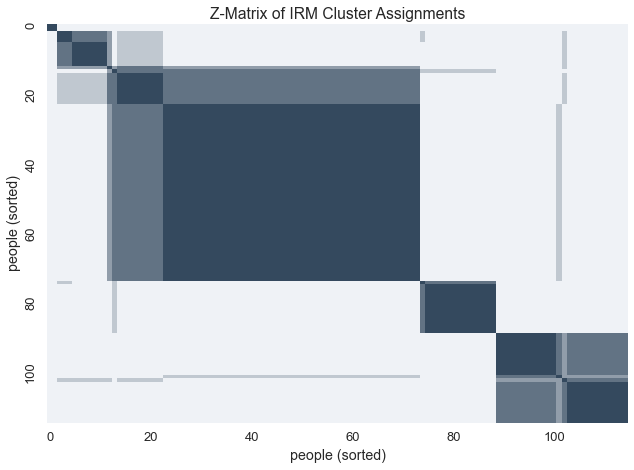

In [14]:
sns.heatmap(zmat, cmap=blue_cmap, cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('people (sorted)')
plt.ylabel('people (sorted)')
plt.title('Z-Matrix of IRM Cluster Assignments')